# Submission

Nama: Jafar Umar Assadulloh

**Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series**

Berikut kriteria submission yang harus Anda penuhi:


1.   Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.

2.   Harus menggunakan LSTM dalam arsitektur model.

3.   Validation set sebesar 20% dari total dataset.

4.   Model harus menggunakan model sequential.


5.   Harus menggunakan Learning Rate pada Optimizer.


6.   MAE < 10% skala data.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dicoding/DailyDelhiClimateTrain.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
# data columns
df.columns

Index(['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

In [ ]:
# total data
df.shape

(1462, 5)

In [ ]:
# categories
df.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

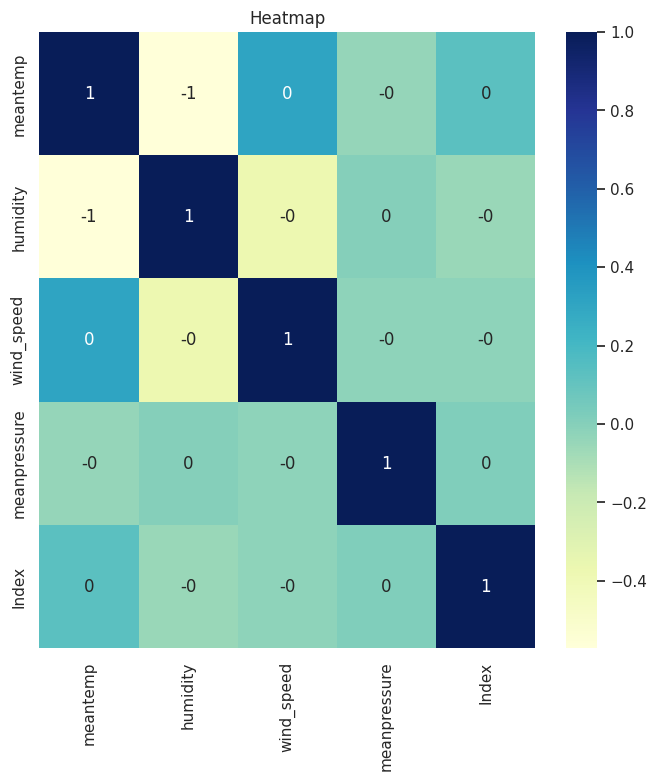

In [ ]:
df['Index'] = range(len(df))
df_notime = df.drop(columns=['date'])
# df
df_notime.corr()
sns.set()
plt.figure(figsize=(8,8))
sns.heatmap(df_notime.corr(), cmap='YlGnBu', annot=True, fmt=".0f")
plt.title('Heatmap')
plt.show()

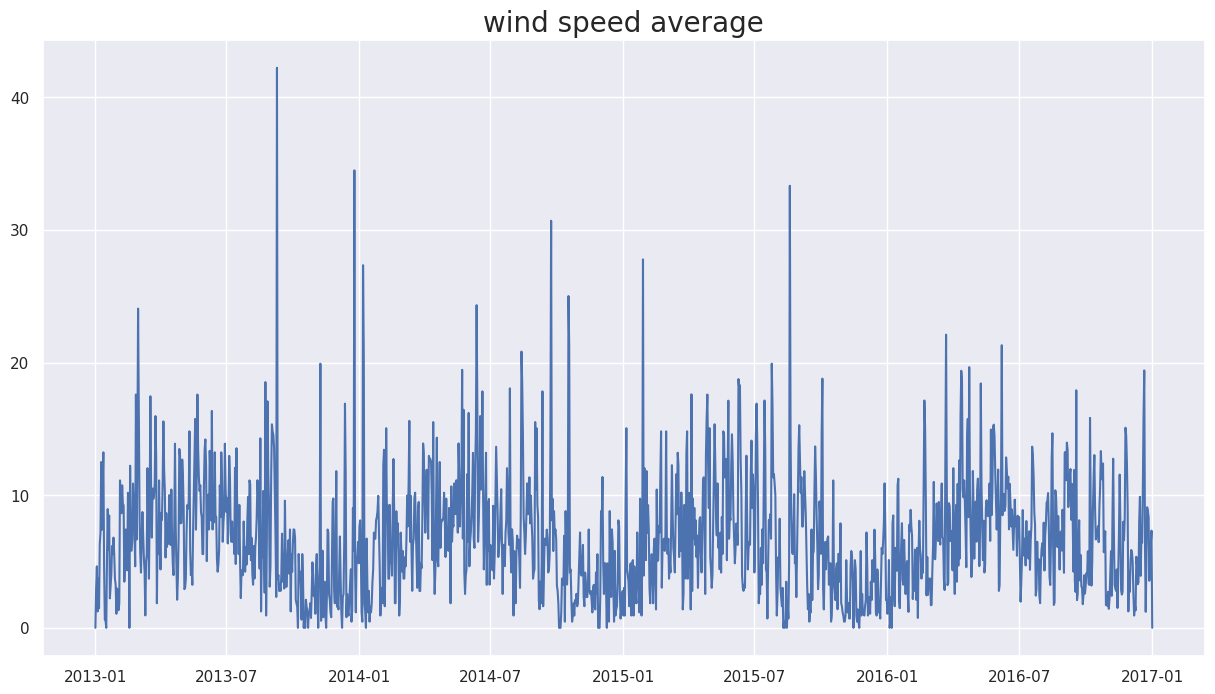

In [ ]:
# df['Date'] = pd.to_datetime(df['date'])
dates = df['date'].values
wind  = df['wind_speed'].values


plt.figure(figsize=(15,8))
plt.plot(dates, wind)
plt.title('wind speed average',
          fontsize=20);

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(wind, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

1169 293


In [ ]:
data_x_train = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=5000)
data_x_test = windowed_dataset(x_test, window_size=60, batch_size=100, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
max = df['wind_speed'].max()
print('Max value : ' )
print(max)

Max value : 
42.22


In [ ]:
min = df['wind_speed'].min()
print('Min Value : ')
print(min)

Min Value : 
0.0


In [ ]:
batas = (max - min) * (10 / 100)
print(batas)

4.222


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< batas):
      self.model.stop_training = True
      print("\nMAE of the model < 10% of data scale")
callbacks = myCallback()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])
history = model.fit(data_x_train ,epochs=500, validation_data=data_x_test, callbacks=[callbacks])

Epoch 1/500
12/12 [==============================] - 7s 144ms/step - loss: 23.4853 - mae: 23.9789 - val_loss: 3.2405 - val_mae: 3.7106
Epoch 2/500
12/12 [==============================] - 1s 36ms/step - loss: 4.6585 - mae: 5.1365 - val_loss: 3.0441 - val_mae: 3.5128
Epoch 3/500
 9/12 [=====================>........] - ETA: 0s - loss: 3.5802 - mae: 4.0530
MAE of the model < 10% of data scale
12/12 [==============================] - 0s 21ms/step - loss: 3.4834 - mae: 3.9552 - val_loss: 2.7516 - val_mae: 3.2184


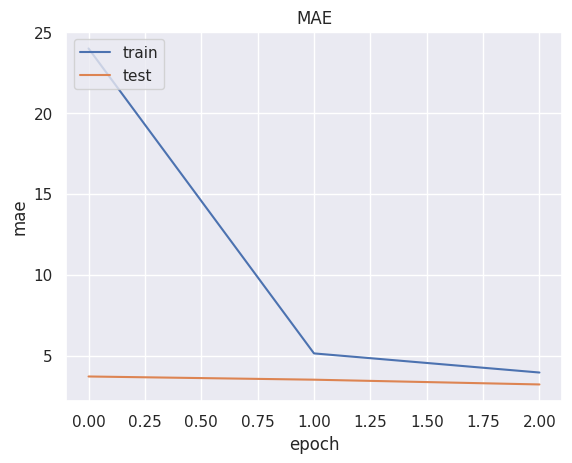

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

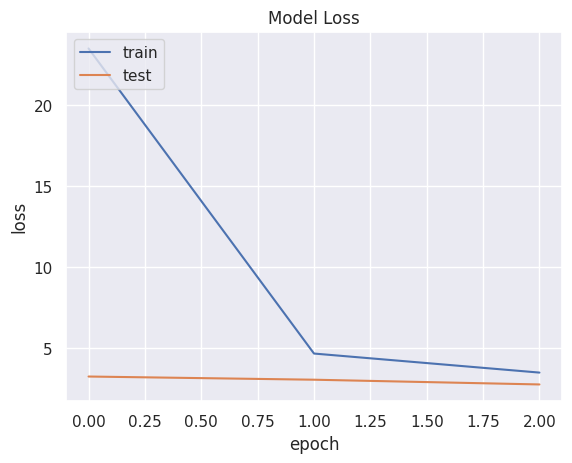

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()